In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils

In [2]:
scenarios = []
for gre in [i/100 for i in list(range(2, 10))]:
    for gs in [i/100 for i in list(range(2, 10))]:
        for ps in [100]:
            for ma in list(range(0, 20001, 5000)):
                for ia in list(range(0, 20001, 5000)):
                    scenarios.append(utils.Scenario(utils.RealEstate(4.2e6,
                                                                     utils.Mortgage(0.0305, 3.6e6, 30, 12)),
                                                    utils.Portfolio(), gre, gs, ps, ma, ia))


sim = utils.Simulation(scenarios)

In [3]:
%%time
sim.simulate()

Completed scenario 1599.
CPU times: user 1min 20s, sys: 33.8 s, total: 1min 54s
Wall time: 1min 52s


In [4]:
history = sim.history
totals = sim.profit

## Historical Market Development
Let's first calculate the historical annual appreciation for real estate in Norway and the S&P500.

In [5]:
real_estate_price_15_y = 73339
real_estate_price_0_y = 27308
snp500_price_15_y = 3235
snp500_price_0_y = 1186
hist_growth_rate_real_estate = math.pow(real_estate_price_15_y/real_estate_price_0_y, 1/15) - 1
hist_growth_rate_snp500 = math.pow(snp500_price_15_y/snp500_price_0_y, 1/15) - 1
print(f'Annual growth rate real estate for the last 15 years: {hist_growth_rate_real_estate:.2%}, '
      f'annual growth rate S&P500 for the last 15 years: {hist_growth_rate_snp500:.2%}.')

Annual growth rate real estate for the last 15 years: 6.81%, annual growth rate S&P500 for the last 15 years: 6.92%.


## Real Estate Profit At Various Overpayment Levels
Here, we fix the annual real estate growth rate to its historic levels and compare the real estate profit for various overpayment amounts.

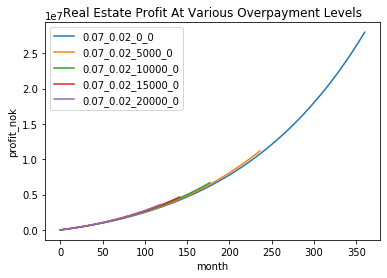

In [6]:
to_plot = history[(history.growth_rate_real_estate==round(hist_growth_rate_real_estate, 2))
                  & (history.growth_rate_stocks==history.growth_rate_stocks.min())
                  & (history.investment_amount==0)]

for scenario in to_plot.scenario_name.unique():
    subplot = history[history.scenario_name==scenario]
    plt.plot(subplot.month, subplot.current_profit_real_estate, label=scenario)

plt.legend()
plt.xlabel('month')
plt.ylabel('profit_nok')
plt.title('Real Estate Profit At Various Overpayment Levels')
plt.show()

## Real Estate Profit At Various Growth Levels With No Overpayment
We will now fix the overpayment to 0 and explore the real estate profit at various annual real estate growth levels.

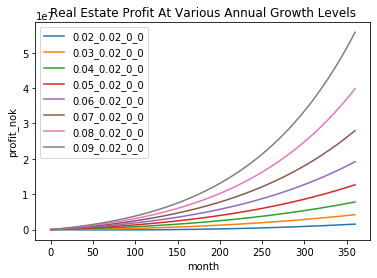

In [7]:
to_plot = history[(history.mortgage_overpayment_amount==0)
                  & (history.growth_rate_stocks==history.growth_rate_stocks.min())
                  & (history.investment_amount==0)]

for scenario in to_plot.scenario_name.unique():
    subplot = history[history.scenario_name==scenario]
    plt.plot(subplot.month, subplot.current_profit_real_estate, label=scenario)

plt.legend()
plt.xlabel('month')
plt.ylabel('profit_nok')
plt.title('Real Estate Profit At Various Annual Growth Levels')
plt.show()

## Real Estate And Stock Profit At Various Growth Rates
Here we look at scenarios where the mortgage overpayment amount equals the investment amount in stocks. However the annual growth rates for stocks and the real estate market may differ.

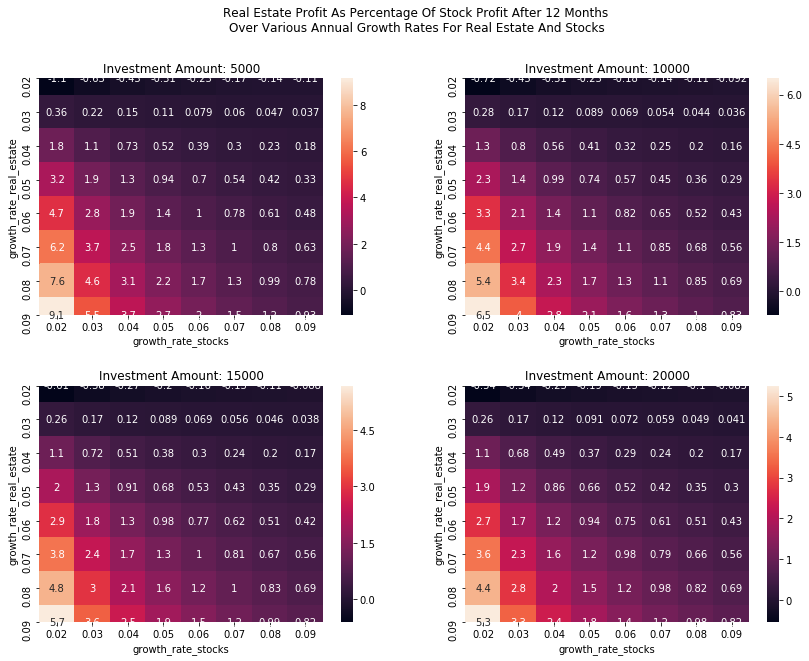

In [8]:
n_months = 12
fig = plt.figure(figsize=(14, 10))
for i, amount in enumerate(list(range(5000, 20001, 5000))):
    to_plot = history[(history.mortgage_overpayment_amount==amount)
                  & (history.investment_amount==amount)
                  & (history.month==n_months)].copy()

    ax = plt.subplot(2, 2, i+1)
    to_plot_pivot = pd.pivot_table(data=to_plot,
                                   index='growth_rate_real_estate',
                                   columns='growth_rate_stocks',
                                   values='profit_ratio')
    sns.heatmap(to_plot_pivot, annot=True)
    plt.title(f'Investment Amount: {amount}')
plt.suptitle(f'Real Estate Profit As Percentage Of Stock Profit After {n_months} Months \nOver Various Annual Growth Rates For Real Estate And Stocks')
plt.subplots_adjust(hspace=0.3)
plt.show()

## Profit Ratio Over Equal Investment Levels And Growth Rates
Here we look at scenarios where the real estate grwoth rate equals the stock market growth rate and the mortgage overpayment equals the stock investment amount. We will plot the profitability ratio over time.

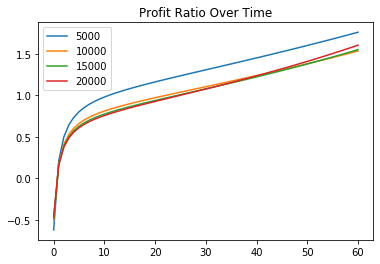

In [13]:
to_plot = history[(history.growth_rate_real_estate==history.growth_rate_stocks)
                  & (history.mortgage_overpayment_amount==history.investment_amount)
                  & (history.investment_amount>0)
                  & (history.growth_rate_stocks==0.07)
                  & (history.month<=60)].copy()

for amount in to_plot.investment_amount.unique():
    subplot = to_plot[to_plot.investment_amount==amount]
    plt.plot(subplot.month, subplot.profit_ratio, label=amount)
plt.legend()
plt.title('Profit Ratio Over Time')
plt.show()

## Equal Growth Rate, No Overpayment, Maximum Investment

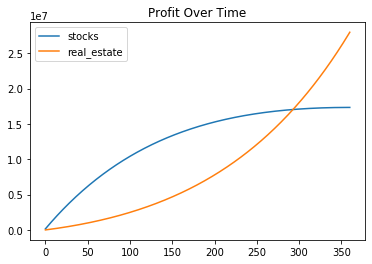

In [22]:
to_plot = history[(history.growth_rate_real_estate==history.growth_rate_stocks)
                  & (history.mortgage_overpayment_amount==0)
                  & (history.investment_amount==2e4)
                  & (history.growth_rate_stocks==0.07)].copy()

plt.plot(to_plot.month, to_plot.cumulative_profit_stocks, label='stocks')
plt.plot(to_plot.month, to_plot.current_profit_real_estate, label='real_estate')

plt.legend()
plt.title('Profit Over Time')
plt.show()

## Equal Growth Rate Various Overpayment And Investment Amounts

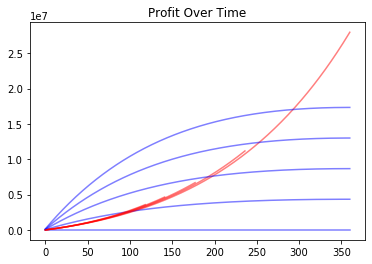

In [24]:
to_plot = history[(history.growth_rate_real_estate==history.growth_rate_stocks)
                  & (history.growth_rate_stocks==0.07)].copy()

for amount in list(range(0, 20001, 5000)):
    subplot_1 = to_plot[(to_plot.investment_amount==amount) & (to_plot.mortgage_overpayment_amount==0)]
    subplot_2 = to_plot[(to_plot.investment_amount==0) & (to_plot.mortgage_overpayment_amount==amount)]
    plt.plot(subplot_1.month, subplot_1.cumulative_profit_stocks, color='b', alpha=0.5)
    plt.plot(subplot_2.month, subplot_2.current_profit_real_estate, color='r', alpha=0.5)

plt.title('Profit Over Time')
plt.show()